# Лабораторная работа № 5
**Вариант:** 9

In [1]:
import numpy as np
from numpy import sin, cos, pi
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import tqdm
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

In [2]:
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina', 'pdf')
plt.rcParams['figure.dpi'] = 100

In [3]:
def plot_history(history, *metrics):
    for metric in metrics:
        print(f"{metric}: {history[metric][-1]:.4f}")
    figure = plt.figure(figsize=(5.5 * len(metrics), 3.5))
    for i, metric in enumerate(metrics, 1):
        ax = figure.add_subplot(1, len(metrics), i)
        ax.xaxis.get_major_locator().set_params(integer=True)
        plt.title(metric)
        plt.plot(history[metric], '-')
    plt.show()

# Cеть Элмана

In [4]:
class ElmanLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super(ElmanLayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.w1 = nn.Parameter(torch.randn(in_features, out_features))
        self.w2 = nn.Parameter(torch.randn(out_features, out_features))
        self.b = nn.Parameter(torch.randn(out_features))
        self.prev = torch.zeros(out_features)
        
    def clear_memory(self):
        self.prev = torch.zeros(self.out_features)
        
    def forward(self, input):
        out = input @ self.w1 + self.b + self.prev @ self.w2
        out = torch.tanh(out)
        self.prev = out.clone().detach()
        return out

In [5]:
def signal(p1, p2, r1, r2, r3, a2, b2, h):
    t1 = np.arange(0, 1, h)
    t2 = np.arange(a2, b2, h)
    
    x1 = p1(t1)
    x2 = p2(t2)
    target1 = np.full(x1.shape, -1)
    target2 = np.full(x2.shape, 1)
    
    x = np.concatenate((np.tile(x1, r1), x2, np.tile(x1, r2), x2, np.tile(x1, r3), x2))
    target = np.concatenate((np.tile(target1, r1), target2, np.tile(target1, r2), target2, np.tile(target1, r3), target2))
    return x, target

def gen_dataset(data, target, window):
    return TensorDataset(
        torch.tensor(np.array([data[i:i+window] for i in range(len(data) - window + 1)]), dtype=torch.float32),
        torch.tensor(np.array([target[i:i+window] for i in range(len(target) - window + 1)]), dtype=torch.float32))

In [6]:
r1, r2, r3 = 7, 0, 7
a2, b2 = 1.13, 3.6
p1 = lambda t: sin(4 * pi * t)
p2 = lambda t: sin(sin(t) * (t ** 2) - t)

In [7]:
data, target = signal(p1, p2, r1, r2, r3, a2, b2, 0.01)

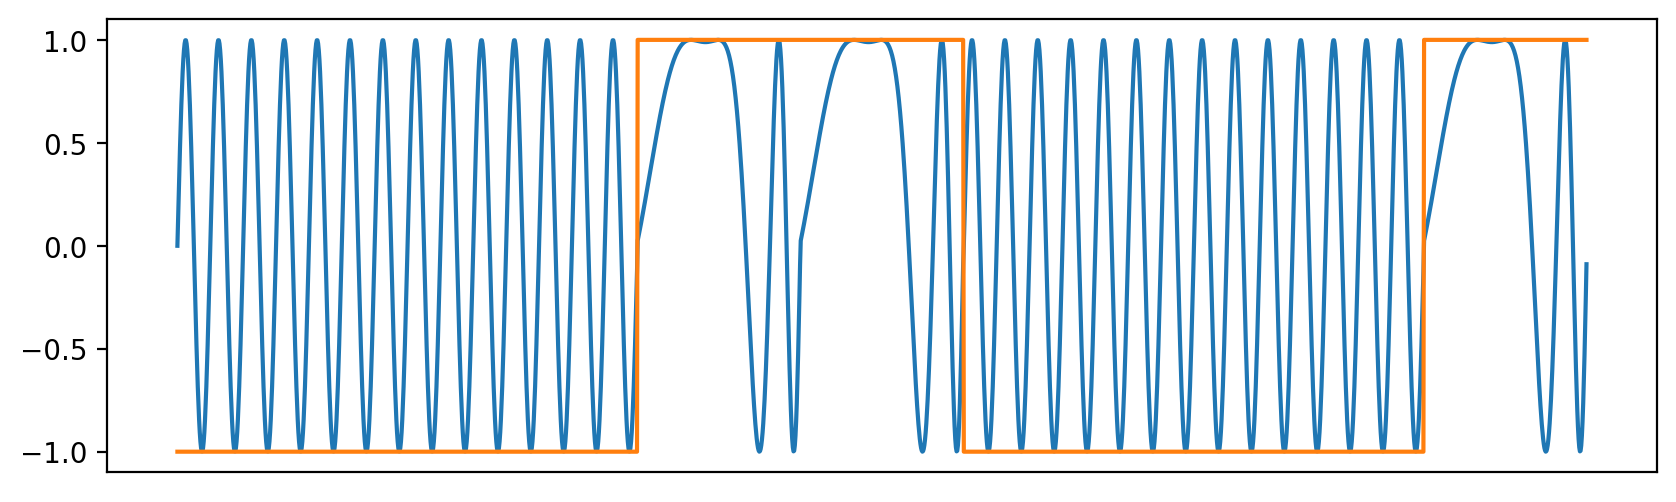

In [8]:
fig = plt.figure(figsize=(10, 3))
plt.xticks([])
plt.plot(data)
plt.plot(target)
plt.show()

In [9]:
window = 8
hidden_layer = 16

In [10]:
dataset = gen_dataset(data, target, window)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

In [17]:
elman = nn.Sequential(
    ElmanLayer(window, hidden_layer),
    nn.Linear(hidden_layer, window)
)

In [18]:
epochs = 150
optim = torch.optim.Adam(elman.parameters(), lr=1e-4)
crit = nn.MSELoss()
history = defaultdict(list)
elman.train()
for epoch in tqdm(range(epochs), desc='Epochs', ncols=70):
    losses = []
    epoch_correct = 0
    epoch_all = 0
    elman[0].clear_memory()
    for x_batch, y_batch in dataloader:
        out = elman(x_batch)
        pred = (out > 0).type(torch.long) * 2 - 1
        loss = crit(out, y_batch)
        
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        losses.append(loss.item())
        epoch_correct += (pred == y_batch).sum().item()
        epoch_all += len(x_batch) * window
    
    history['accuracy'].append(epoch_correct / epoch_all)
    history['loss'].append(np.mean(losses))

Epochs: 100%|███████████████████████| 150/150 [05:23<00:00,  2.16s/it]


loss: 0.0759
accuracy: 0.9770


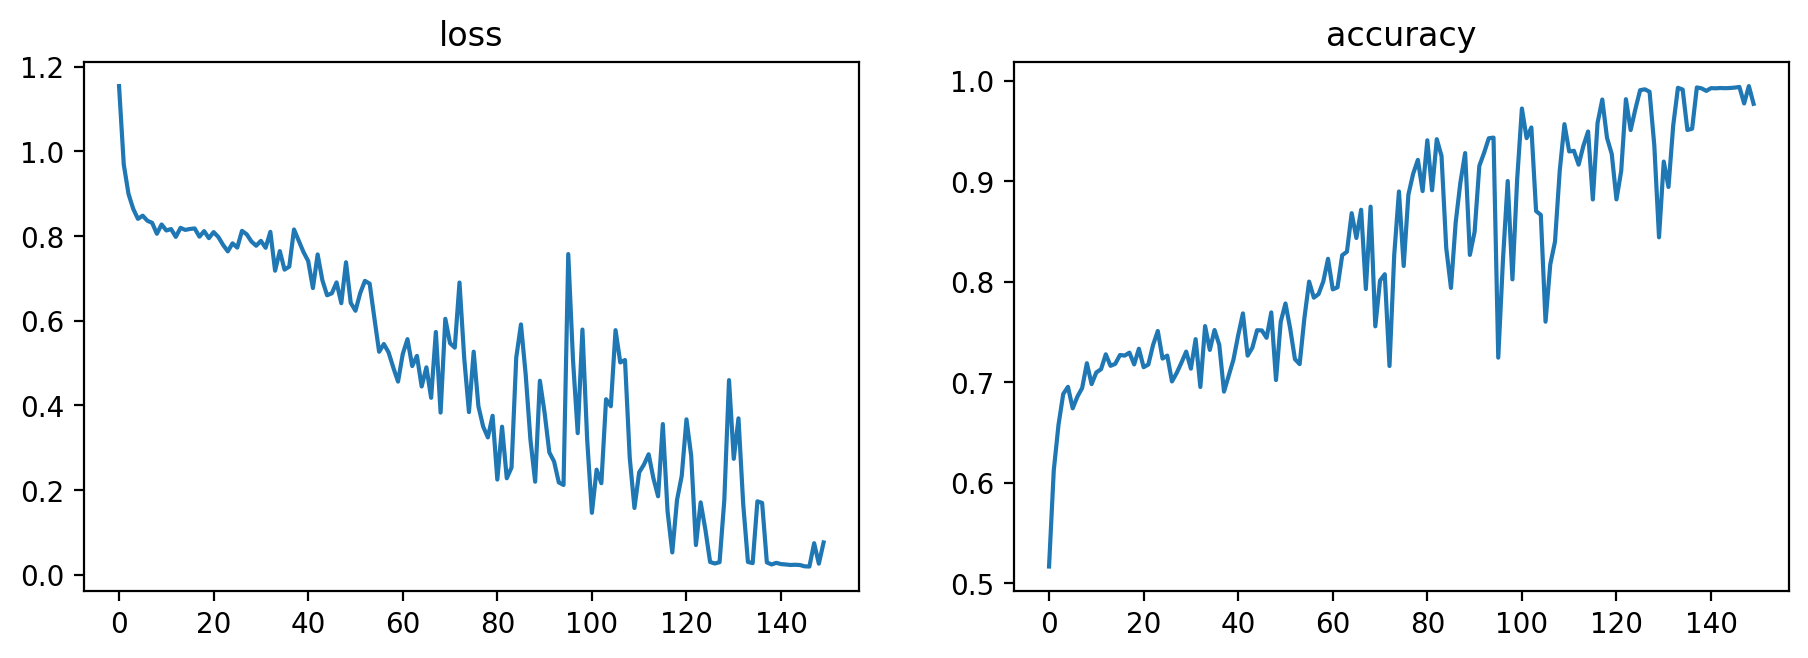

In [19]:
plot_history(history, 'loss', 'accuracy')

In [20]:
elman.eval()
pred = []
for x, _ in dataset:
    pred.append(elman(x).detach().numpy().item(0))
pred.extend(elman(dataset[-1][0]).detach().numpy()[1:])
pred = np.array(pred)
pred = (pred > 0) * 2 - 1

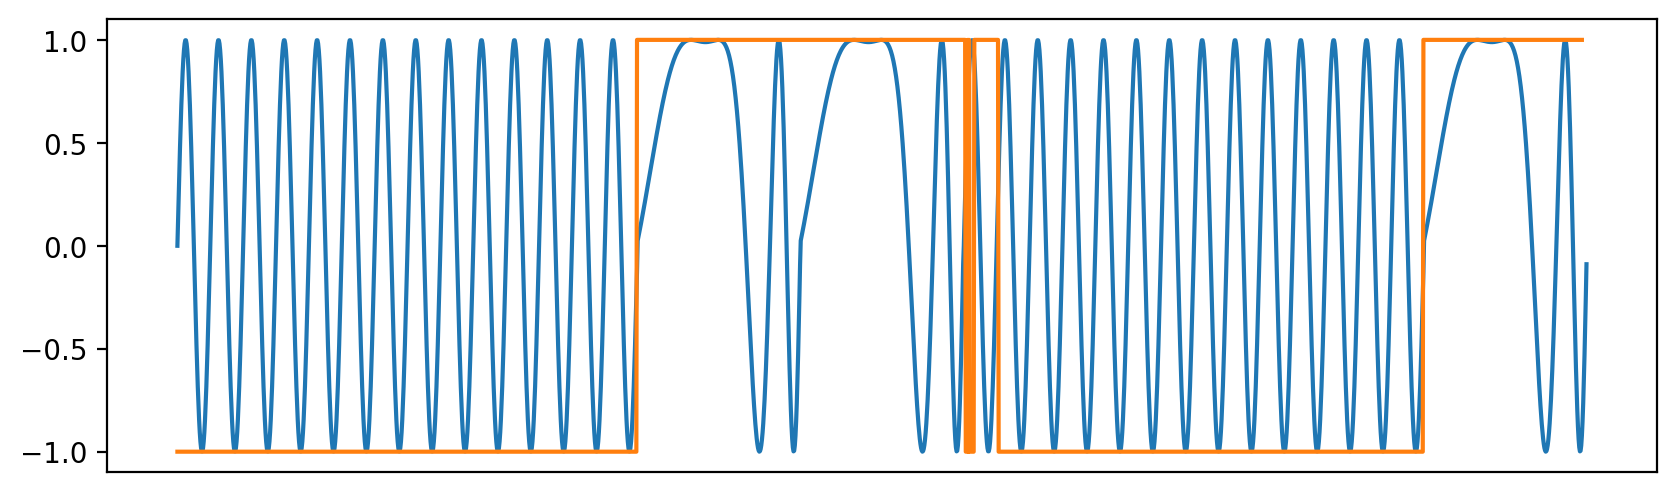

In [21]:
fig = plt.figure(figsize=(10, 3))
plt.xticks([])
plt.plot(data)
plt.plot(pred)
plt.show()

# Сеть Хопфилда

In [4]:
def load_image(path, width=320, height=240):
    image = Image.open(path)
    image = image.convert('RGB')  # удалить альфа канал, иногда он может присутствовать!
    image = image.resize((width, height), Image.ANTIALIAS)
    image = np.asarray(image, dtype=np.float32)
    image = np.dot(image[..., :3], [0.2989, 0.5870, 0.1140]).astype(np.float32)  # получить float32 вместо double
    image = (image - 127.5) / 127.5  # нормализовать [-1..1]
    return image.flatten()

In [5]:
class HopfieldLayer(nn.Module):
    def __init__(self, in_features):
        super(HopfieldLayer, self).__init__()
        self.w = nn.Parameter(torch.zeros(in_features, in_features))
        self.b = nn.Parameter(torch.zeros(in_features))
        self.prev = torch.zeros(in_features)
        
    def set_initial_value(self, value):
        self.prev = value.detach().clone()
        
    def forward(self, input=0):
        out = torch.matmul(self.prev, self.w)
        out = torch.add(out, self.b)
        out = torch.clamp(out, min=-1, max=1)
        self.prev = out.detach().clone()
        return out

In [6]:
width = 10
height = 12

In [7]:
def load_images():
    return [
        load_image('img/zero.png', width, height),
        load_image('img/nine.png', width, height),
        load_image('img/two.png', width, height),
    ]

In [8]:
images = load_images()
dataloader = DataLoader(images, batch_size=1, shuffle=True)

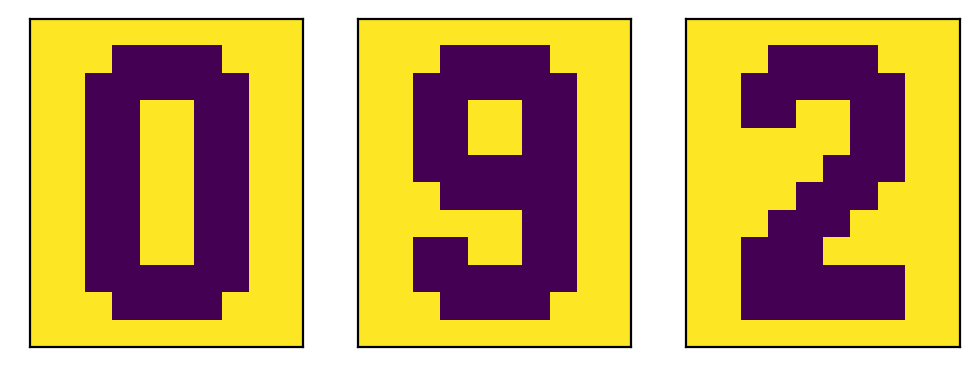

In [9]:
fig = plt.figure(figsize=(len(images) * 2, 4))
for i, img in enumerate(images):
    ax = fig.add_subplot(1, len(images), i+1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.imshow(img.reshape(height, width))
plt.show()

In [13]:
hopfield = HopfieldLayer(width * height)

In [14]:
epochs = 1500
optim = torch.optim.Adam(hopfield.parameters(), lr=1e-5)
crit = nn.MSELoss()
history = defaultdict(list)
hopfield.train()

for epoch in tqdm(range(epochs), desc='Epochs', ncols=70):
    for img in dataloader:
        losses = []
        hopfield.set_initial_value(img)
        out = hopfield()
        loss = crit(out, img)

        optim.zero_grad()
        loss.backward()
        optim.step()

        losses.append(loss.item())

        history['loss'].append(np.mean(losses))

Epochs: 100%|████████████████████| 1500/1500 [00:03<00:00, 408.79it/s]


loss: 0.0425


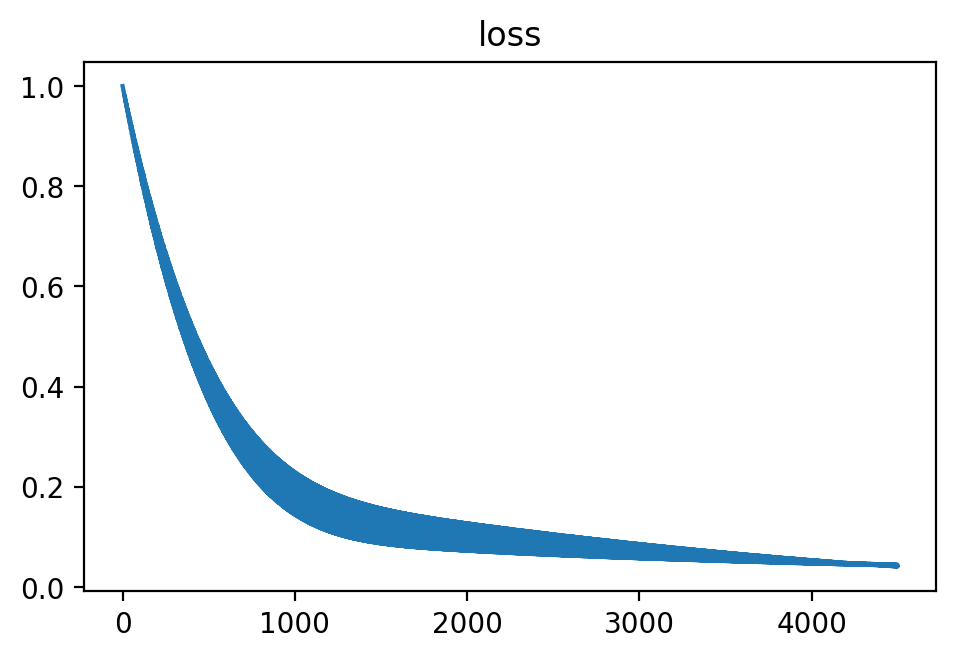

In [15]:
plot_history(history, 'loss')

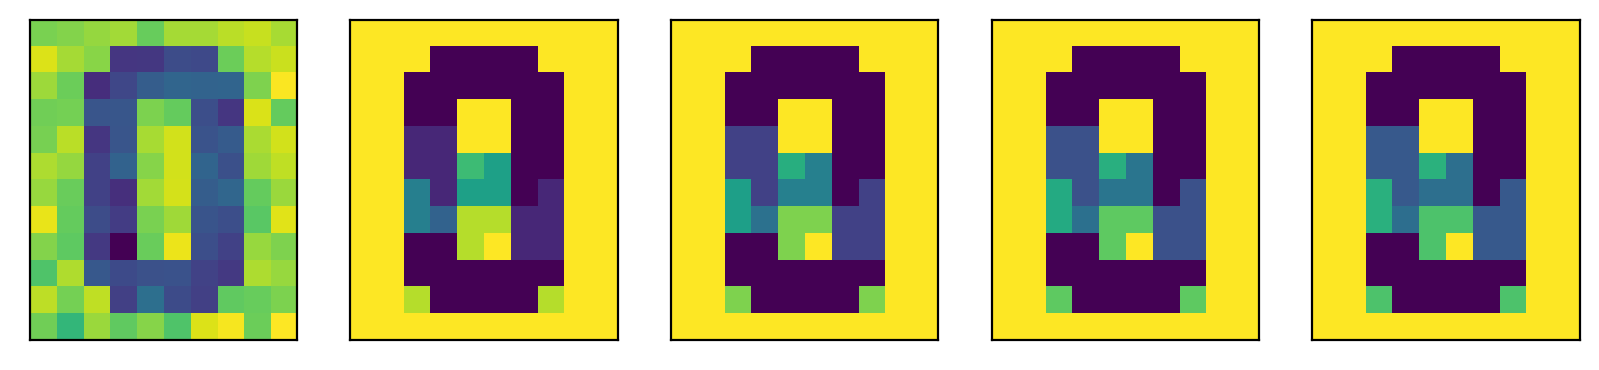

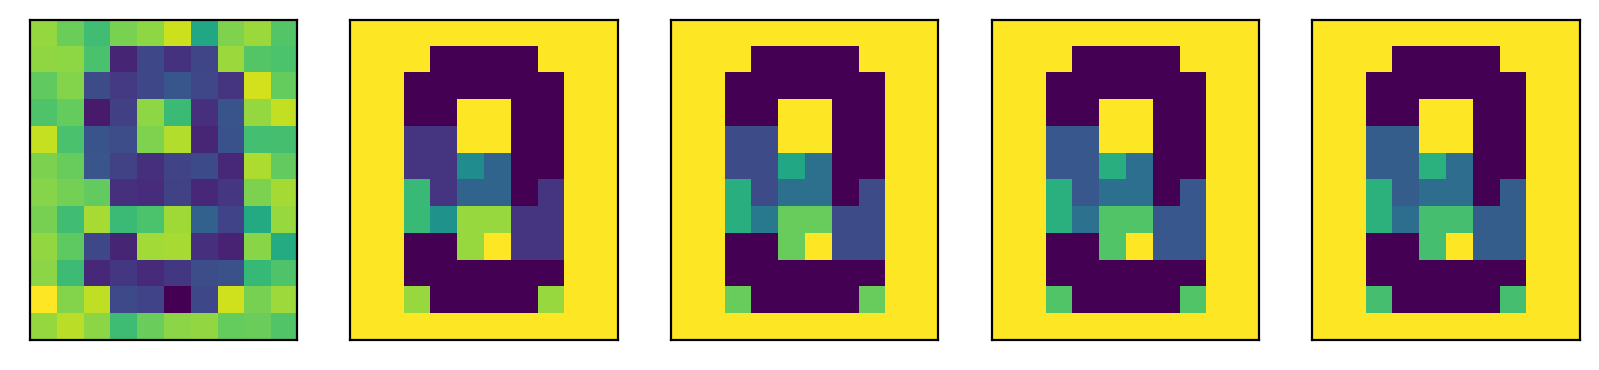

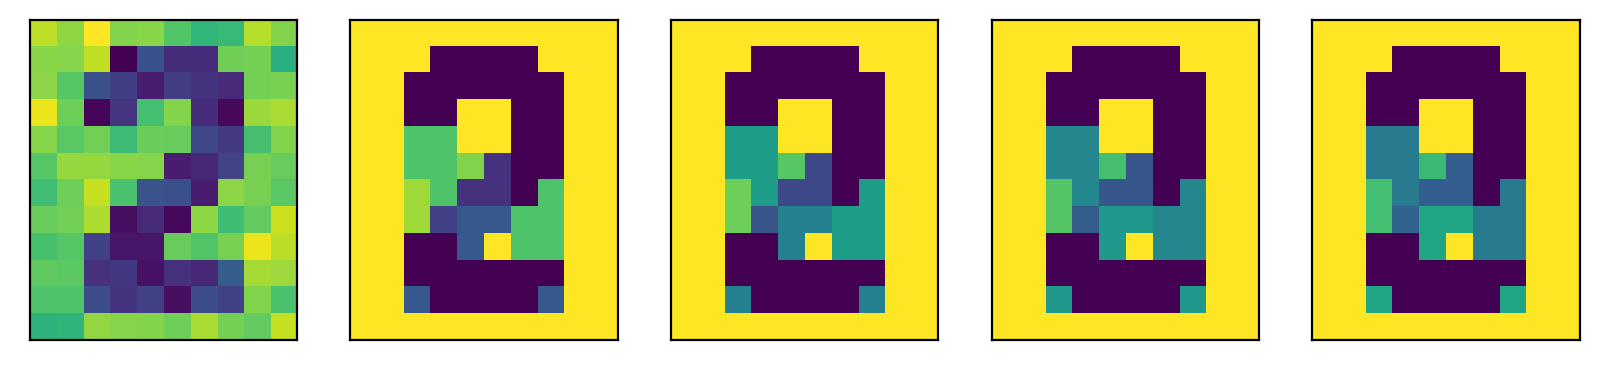

In [16]:
for img in images:
    out = torch.clamp(torch.tensor(img) + torch.randn(img.shape) / 4, -2, 2) / 2

    hopfield.eval()
    hopfield.set_initial_value(out)
    steps = 5
    fig = plt.figure(figsize=(steps * 2, 4))
    for i in range(steps):
        ax = fig.add_subplot(1, steps, i+1)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.imshow(out.detach().numpy().reshape(height, width))
        out = hopfield()
    plt.show()